In [22]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import compose
from sklearn import impute
from sklearn import model_selection
from sklearn import feature_selection
from sklearn import tree
from sklearn import pipeline
from sklearn import ensemble
from sklearn import metrics

from scipy import stats

import graphviz
from tqdm import tqdm
import joblib

In [3]:
df = pd.read_csv("data/final_train.csv", index_col=0)
df.head()

,Activity,"angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyAccMean,gravity)","angle(tBodyGyroJerkMean,gravityMean)","angle(tBodyGyroMean,gravityMean)",energy-mean(),"fBodyAcc-bandsEnergy()-1,16",...,tGravityAccMag-energy(),tGravityAccMag-entropy(),tGravityAccMag-iqr(),tGravityAccMag-mad(),tGravityAccMag-max(),tGravityAccMag-mean(),tGravityAccMag-min(),tGravityAccMag-sma(),tGravityAccMag-std(),void()
0,STANDING,-1.574191,-0.805700,-2.453831,-1.861714,0.115517,-2.023369,3.125860,-9.474436,3.622600,...,5.049130,3.272281,5.103018,-0.823302,3.063681,-0.928676,-1.007695,3.094236,1.669987,1.0
1,WALKING_UPSTAIRS,-1.568669,-0.612620,-2.488338,-1.751117,0.218134,0.280294,7.953403,-0.679894,2.512880,...,4.565443,4.440779,3.288399,-2.689605,1.705341,-0.822617,-0.572410,-2.187890,-0.544652,2.0
2,LAYING,-1.548333,-0.139628,-2.380889,-1.915239,0.067613,-0.887342,6.007361,-11.906904,3.621984,...,5.059609,2.296603,5.344174,-0.549843,3.272225,-0.940610,-1.031522,-2.071755,2.024442,3.0
3,WALKING,-1.574094,-0.793443,-2.449959,-1.842741,-0.195625,-0.950671,2.104353,-11.906121,3.355701,...,4.860758,4.177535,3.950012,-0.322642,2.366287,-0.866937,-0.696431,1.863375,0.550414,2.0
4,LAYING,-1.548333,-0.139628,-2.380889,NaN,0.067613,-0.887342,6.007361,-11.970485,3.621984,...,5.059609,2.296603,5.344174,-0.549843,3.272225,-0.940610,-1.031522,-2.102513,2.024442,3.0


In [4]:
df = df.drop(columns=["subject", "void()"])
df = df.dropna()

In [5]:
y = df["Activity"]
X = df.drop(columns=["Activity"])
X.shape, y.shape

((9624, 569), (9624,))

In [6]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
tree_clf = tree.DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [8]:
path = tree_clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

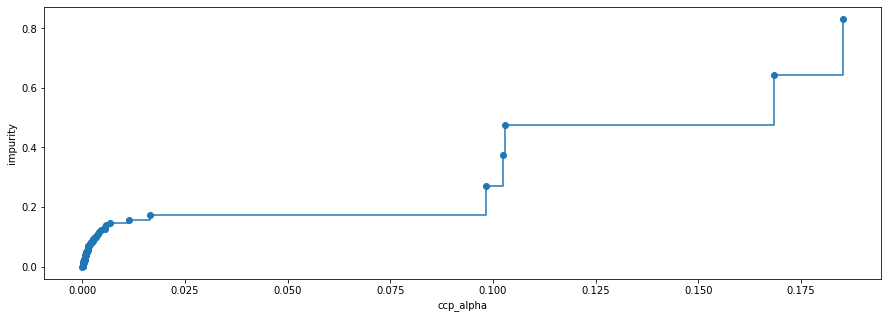

In [9]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(ccp_alphas, impurities, marker='o', drawstyle="steps-post")
ax.set_xlabel("ccp_alpha")
ax.set_ylabel("impurity")
plt.show()

In [11]:
clfs = [
    tree.DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha).fit(X_train, y_train)
    for ccp_alpha in tqdm(ccp_alphas)
]

100%|██████████| 123/123 [06:25<00:00,  3.13s/it]


In [12]:
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

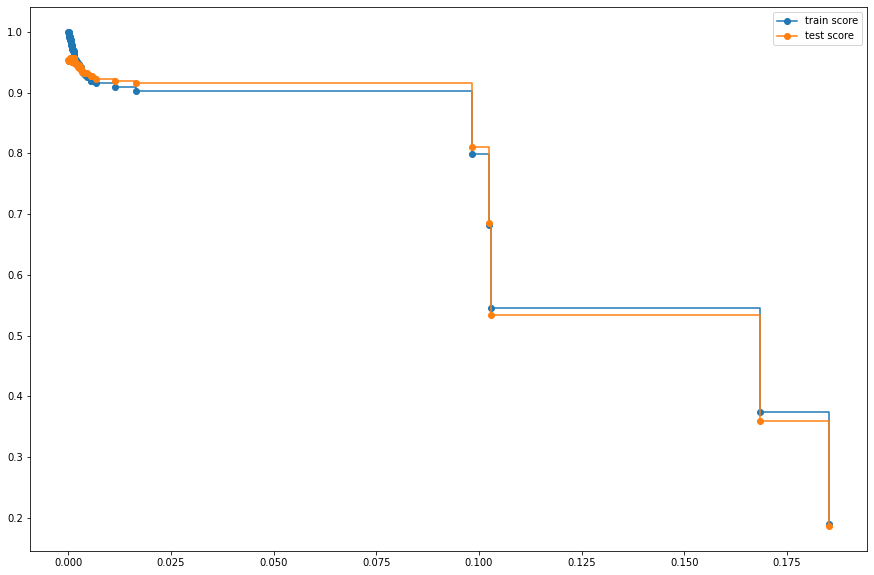

In [13]:
fig, ax = plt.subplots(figsize=(15, 10))

ax.plot(ccp_alphas, train_scores, marker='o', drawstyle="steps-post", label="train score")
ax.plot(ccp_alphas, test_scores, marker='o', drawstyle="steps-post", label="test score")
ax.legend()

plt.show()

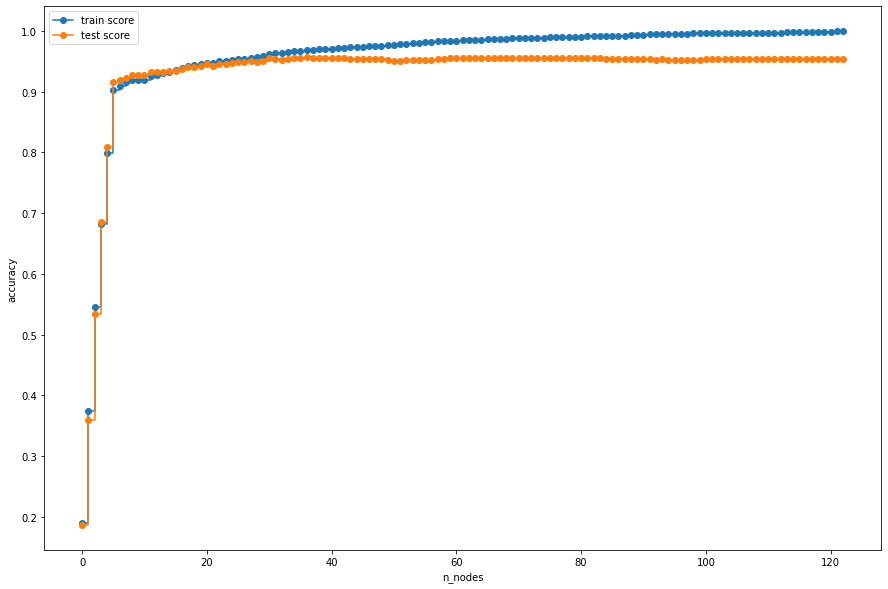

In [14]:
fig, ax = plt.subplots(figsize=(15, 10))

ax.plot(range(len(train_scores)), train_scores[::-1], marker='o', drawstyle="steps-post", label="train score")
ax.plot(range(len(test_scores)), test_scores[::-1], marker='o', drawstyle="steps-post", label="test score")

ax.set_ylabel("accuracy")
ax.set_xlabel("n_nodes")
ax.legend()

plt.show()

In [17]:
alpha = ccp_alphas[-6]
alpha

0.016560535464247086

In [18]:
final_tree_clf = tree.DecisionTreeClassifier(random_state=42, ccp_alpha=alpha)
final_tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.016560535464247086, random_state=42)

In [19]:
final_tree_clf.score(X_test, y_test)

0.9158441558441558

In [20]:
dot_data = tree.export_graphviz(
    final_tree_clf,
    feature_names=X.columns,
    class_names=final_tree_clf.classes_
)
graph = graphviz.Source(dot_data)
graph.render("result")

'result.pdf'

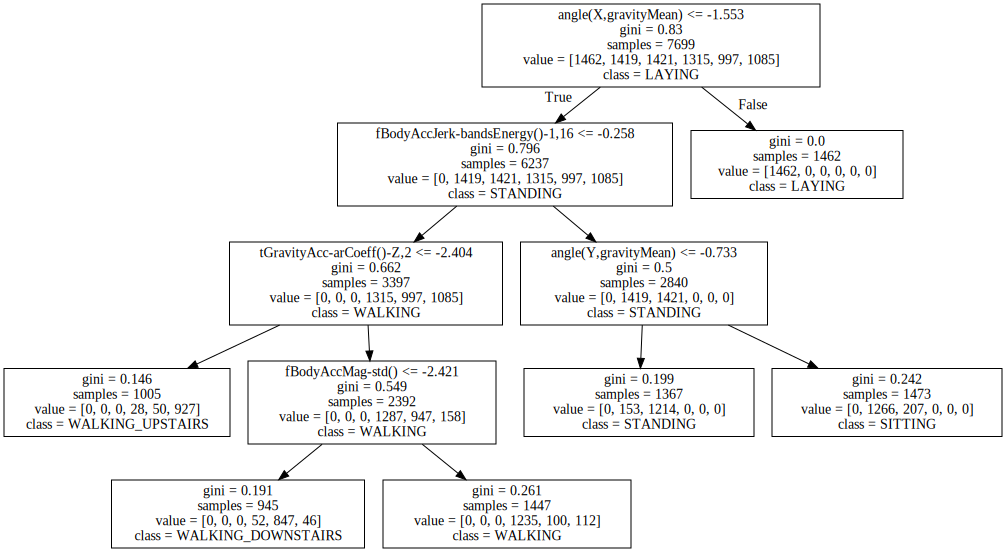

In [32]:
graph

In [29]:
joblib.dump(final_tree_clf, "tree.joblib")

['tree.joblib']

In [30]:
print(metrics.classification_report(y_test, final_tree_clf.predict(X_test)))

                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       359
           SITTING       0.88      0.92      0.90       370
          STANDING       0.90      0.86      0.88       332
           WALKING       0.88      0.96      0.92       337
WALKING_DOWNSTAIRS       0.91      0.87      0.89       243
  WALKING_UPSTAIRS       0.92      0.87      0.89       284

          accuracy                           0.92      1925
         macro avg       0.92      0.91      0.91      1925
      weighted avg       0.92      0.92      0.92      1925



In [31]:
metrics.confusion_matrix(y_test, final_tree_clf.predict(X_test))

array([[359,   0,   0,   0,   0,   0],
       [  0, 340,  30,   0,   0,   0],
       [  0,  47, 285,   0,   0,   0],
       [  0,   0,   0, 322,   7,   8],
       [  0,   0,   0,  19, 211,  13],
       [  0,   0,   0,  25,  13, 246]])